In [1]:
import pandas as pd; pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../scripts')
from PreparaDataset import *

In [2]:
data = pd.read_csv('../data/NFL.csv')

In [3]:
dataframe = prepara_df(data)
dataframe = dataframe[dataframe['Season_Time'] != 'Nfl - All-Stars - Final']

dataframe.loc[(((dataframe['Home_Pts'] + dataframe['HA_Line']) > dataframe['Away_Pts'])), 'Back_AH'] = 1
dataframe.loc[(((dataframe['Home_Pts'] + dataframe['HA_Line']) < dataframe['Away_Pts'])), 'Back_AH'] = 0
dataframe.loc[(((dataframe['Home_Pts'] + dataframe['HA_Line']) == dataframe['Away_Pts'])), 'Back_AH'] = 2

dataframe = dataframe[dataframe['Back_AH'] != 2]

dataframe.dropna(inplace=True)
dataframe.reset_index(drop=True, inplace=True)

c:\Users\johnn\Documents\venvs\nfl_models\ML\../scripts\PreparaDataset.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df.loc[(_df['Home_Pts'] > _df['Away_Pts']), 'Back_Home'] = 1
c:\Users\johnn\Documents\venvs\nfl_models\ML\../scripts\PreparaDataset.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df.loc[(_df['Home_Pts'] < _df['Away_Pts']), 'Back_Away'] = 1
c:\Users\johnn\Documents\venvs\nfl_models\ML\../scripts\PreparaDataset.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy

In [ ]:
print(f'Odd média: {dataframe.HA_Odds_H.mean():.2f} ({1 / (dataframe.HA_Odds_H.mean()):.2f}) | Média Back Home: {dataframe.Back_AH.mean():.2f}')
print(f'Tamanho da amostra: {dataframe.shape[0]}')

In [4]:
div = len(dataframe)
div = 150
treino = dataframe.iloc[:div, :]
val = dataframe.iloc[div: , :]

print(f'Treino: {treino.shape[0]} | Validação: {val.shape[0]}')

Treino: 150 | Validação: 336


In [6]:
features = ['Odds_H', 'Odds_A', 'Over_Line', 'HA_Line', 'P_Diff',
       'Avg_CG_H', 'Avg_CG_A', 'DP_CG_A', 'Last_CG_H', 'Last_CG_A']
features = colunas

In [7]:
from pycaret.classification import *

cls = setup(data = dataframe,
            ignore_features = [x for x in dataframe.columns.to_list() if x not in features and x != 'Back_AH'],
            target = 'Back_AH',
            train_size = 0.5,
            normalize = True,
            normalize_method = 'zscore',
            session_id = 2023,
            verbose = False
            )

xtrain_treino = get_config('X_train')
ytrain_treino = get_config('y_train')
xtrain_teste = get_config('X_test')
ytrain_teste = get_config('y_test')

real_treino = pd.concat([xtrain_treino, ytrain_treino], axis=1)
real_teste = pd.concat([xtrain_teste, ytrain_teste],  axis=1)

In [ ]:
model = compare_models(sort = 'precision', cross_validation = False, include = ['lr', 'dt', 'et', 'knn', 'ridge', 'rf', 'rbfsvm', 'nb'])

In [ ]:
model = create_model('nb', fold=5, return_train_score=True)

In [ ]:
ensembled = ensemble_model(model, fold = 5, optimize='precision', return_train_score=True)

In [ ]:
def info_modelo(modelo, data=None):
    if data is None:
        pred = predict_model(modelo, verbose = False)
    else:
        pred = predict_model(modelo, data, verbose = False)

    pred = pred.merge(dataframe['HA_Odds_H'], left_index=True, right_index=True, how='left')
    if 'HA_Odds_H_x' in pred.columns.tolist():
        pred.rename(columns={'HA_Odds_H_x': 'HA_Odds_H'}, inplace=True)
        pred.drop(columns='HA_Odds_H_y', inplace=True)
    
    stake = 1

    total = pred.shape[0]

    # Filtro 1
    # pred = pred[(pred['CV_ML'] >= 0.3)]

    pred.loc[(pred['Back_AH'] == 0), 'PL_BF_Predictions'] = - stake
    pred.loc[(pred['Back_AH'] == 1), 'PL_BF_Predictions'] = ((pred['HA_Odds_H']) - 1) * stake
    
    reserva = pred.copy()
    pred = pred[(pred['prediction_label'] == 1)]

    plb = pred['PL_BF_Predictions'].sum()
    entradas = pred[pred['prediction_label'] == 1].shape[0]
    wr = round((pred[pred['Back_AH'] == 1].shape[0] / entradas), 2)
    oddback = pred['HA_Odds_H'].mean()
    med_gain = pred[pred['Back_AH'] == 1]['PL_BF_Predictions'].mean()
    med_loss = pred[pred['Back_AH'] == 0]['PL_BF_Predictions'].mean()
    roi = plb / entradas
    porc_ent = entradas / total
    ev = (wr*stake*med_gain) + ((1-wr)*med_loss*stake)
    print(f'PL: {plb:.2f} | ROI: {100*roi:.2f}% | Prec.: {wr:.2f}')
    print(f'Odd média: {oddback:.2f}')
    print(f'Média Gain: {med_gain:.2f} | Média Loss: {med_loss:.2f}')
    print(f'EM: {ev:.2f}')
    print(f'{entradas} entradas em {total} jogos ({100*porc_ent:.2f}%)')

    pred.sort_index(inplace=True)
    pred['hbacu'] = pred['PL_BF_Predictions'].cumsum()
    pred = pred[pred['prediction_label'] == 1]
    pred.reset_index(drop=True, inplace=True)

    pred['hbacu'].plot.line(figsize=(6,2))

    return reserva

In [ ]:
tuned = tune_model(model, fold=5, optimize='precision', return_train_score=True, search_library='scikit-optimize', search_algorithm='bayesian', n_iter=20)

In [ ]:
df_treino = info_modelo(model, real_treino)

In [ ]:
df_treino = info_modelo(model, real_teste)

<Axes: >

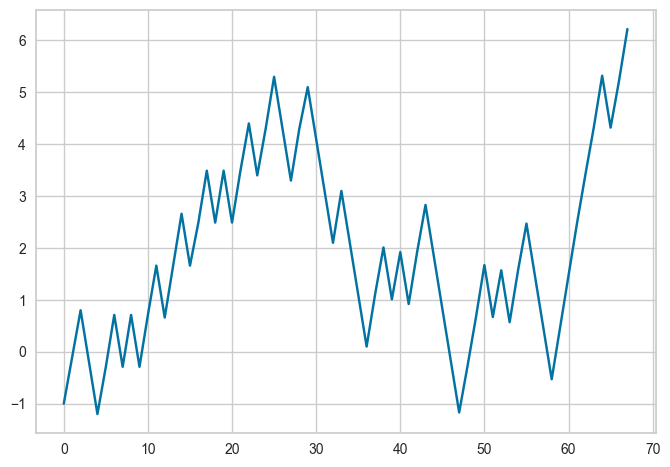

In [17]:
treinito = real_treino.copy()
treinito = treinito[(treinito['Avg_CG_H'] >= 1) & (treinito['Avg_CG_H'] < 41)]

treinito.loc[(treinito['Back_AH'] == 1), 'Profit'] = treinito['HA_Odds_H'] - 1
treinito.loc[(treinito['Back_AH'] == 0), 'Profit'] = - 1

treinito.sort_index(inplace=True)
treinito.reset_index(drop=True, inplace=True)
treinito['hbacu'] = treinito['Profit'].cumsum()
treinito['hbacu'].plot()

<Axes: >

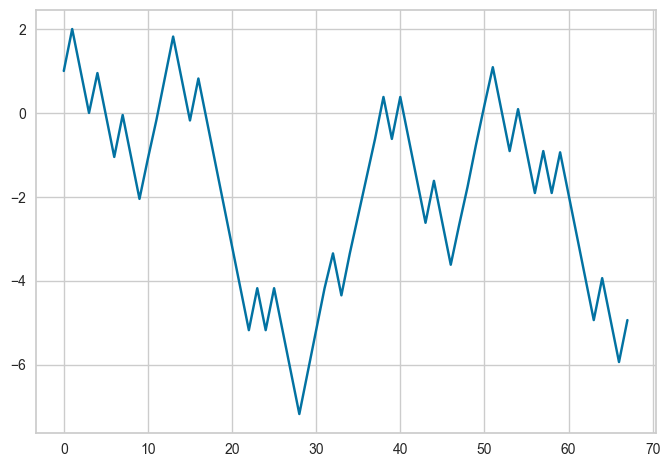

In [20]:
validacao = real_teste.copy()
validacao = validacao[(validacao['DP_CG_A'] >= 30)]

validacao.loc[(validacao['Back_AH'] == 1), 'Profit'] = validacao['HA_Odds_H'] - 1
validacao.loc[(validacao['Back_AH'] == 0), 'Profit'] = - 1

validacao.sort_index(inplace=True)
validacao.reset_index(drop=True, inplace=True)
validacao['hbacu'] = validacao['Profit'].cumsum()
validacao['hbacu'].plot()

# Script variáveis

In [5]:
colunas = ['Odds_H', 'Odds_A', 'Over_Line', 'Odds_Over', 'Odds_Under',
       'HA_Line', 'HA_Odds_H', 'HA_Odds_A', 'P(H)', 'P(A)', 'P(O)', 'P(U)', 'P_Diff',
       'Porc_Over_Home', 'Porc_Over_Away','Avg_CG_H', 'DP_CG_H', 'CV_CG_H', 'Avg_CG_A', 'DP_CG_A', 'CV_CG_A',
       'Last_CG_H', 'Last_CG_A', 'Acima_Last_CG_H', 'Acima_Last_CG_A',
       'Abaixo_Last_CG_H', 'Abaixo_Last_CG_A', 'CV_ML', 'CV_Over']

In [ ]:
import random

def pegar_elementos_aleatorios(lista):
    # Gerar um número aleatório entre 2 e 7
    num_elementos = random.randint(2, 13)

    # Garantir que o número de elementos não ultrapasse o tamanho da lista
    num_elementos = min(num_elementos, len(lista))

    # Selecionar elementos aleatórios da lista
    elementos_aleatorios = random.sample(lista, num_elementos)

    return elementos_aleatorios

In [ ]:
melhor_PL = -10000

for i in range(30):
    features = pegar_elementos_aleatorios(colunas)

    cls = setup(data = dataframe,
            ignore_features = [x for x in dataframe.columns.to_list() if x not in features and x != 'Back_AH'],
            target = 'Back_AH',
            train_size = 0.5,
            normalize = True,
            normalize_method = 'zscore',
            session_id = 2023,
            verbose = False
            )
    
    model = create_model('nb', verbose = False, fold = 5)
    tab = pull()
    prec_model = (tab.loc['Mean', 'Prec.'])
    dp_model = (tab.loc['Std', 'Prec.'])
    pred = predict_model(model, verbose = False)
    stake = 1

    pred = pred.merge(dataframe['HA_Odds_H'], left_index=True, right_index=True, how='left')
    if 'HA_Odds_H_x' in pred.columns.tolist():
        pred.rename(columns={'HA_Odds_H_x': 'HA_Odds_H'}, inplace=True)
        pred.drop(columns='HA_Odds_H_y', inplace=True)

    total = pred.shape[0]

    pred.loc[(pred['Back_AH'] == 0), 'PL_BF_Predictions'] = - stake
    pred.loc[(pred['Back_AH'] == 1), 'PL_BF_Predictions'] = ((pred['HA_Odds_H']) - 1) * stake
    
    reserva = pred.copy()
    pred = pred[(pred['prediction_label'] == 1)]

    plb = pred['PL_BF_Predictions'].sum()
    entradas = pred[pred['prediction_label'] == 1].shape[0]
    wr = round((pred[pred['Back_AH'] == 1].shape[0] / entradas), 2)
    oddback = pred['HA_Odds_H'].mean()
    med_gain = pred[pred['Back_AH'] == 1]['PL_BF_Predictions'].mean()
    med_loss = pred[pred['Back_AH'] == 0]['PL_BF_Predictions'].mean()
    roi = plb / entradas
    porc_ent = entradas / total
    ev = (wr*stake*med_gain) + ((1-wr)*med_loss*stake)

    if prec_model / dp_model > melhor_PL:
        best_model = model
        melhor_PL = prec_model
        print(f'**Novo melhor** PL: {plb:.2f} | EM: {ev:.2f} | Prec.: {prec_model:.4f}')
        print(f'Features: {features}\n')

In [ ]:
modelo_salvo = best_model

In [ ]:
modelo_salvo